In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import coolname
from third_party.gmm_torch.gmm import GaussianMixture
from card_1_lib import wolf_dens, plot_distribution
from random import random

### In this notebook we're going to be dealing with false information

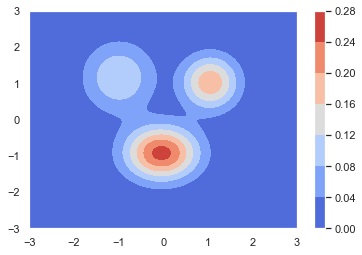

In [2]:

class Explorer:
    """
    A class used to represent our explorers. 
    Attributes:
    environment : GaussianMixture
        The environment the explorer samples from
    model : GaussianMixture
        The internal model the explorer has of its environment
    experiences : Tensor
        A buffer containing samples from the environment.
    name : string
        The explorer's name
    """
    def __init__(
        self,
        environment: GaussianMixture = wolf_dens,
        model: GaussianMixture = None,
    ) -> None:
        """Initializes the explorer with a given environment and internal model"""
        self.environment = environment
        self.model = model
        self.experiences = torch.empty(0, 2)
        self.notes = {}
        self.trusted_notes = {}
        self.name = coolname.generate_slug(3)
    
    def sample(self, n: int) -> None:
        """Draws n samples from the environment, and adds them to experience buffer"""
        samples, _ = self.environment.sample(n)
        self.experiences = torch.cat([self.experiences, samples])

    def fit(self, samples) -> None:
        """Fits internal model to experiences"""
        self.model = GaussianMixture(n_components=3, n_features=2, covariance_type="diag")
        self.model.fit(samples)
    
    def display(self, show=True, **kwargs) -> None:
        """Displays GMM"""
        plot_distribution(self.model, **kwargs)
        if show:
            plt.xlim([-3, 3])
            plt.ylim([-3, 3])
            plt.show()

    def believed_locations(self, notes) -> torch.tensor:
        """Displays all believed wolf locations, experienced and in notes"""
        return torch.cat([self.experiences] + [note for note in notes.values()])

    def __repr__(self) -> str:
        return self.name


explorer_1 = Explorer()
explorer_1.sample(100)
explorer_1.fit(explorer_1.experiences)
plot_distribution(explorer_1.model)

But what about the case of false information?

In our example conniving fox doesn't want the explorers to build by its den, and is leaving behind notes that report fox sightings as if they were wolf sightings! There is one fox den at -2, -1. See it in red next to the wolf dens, below. 

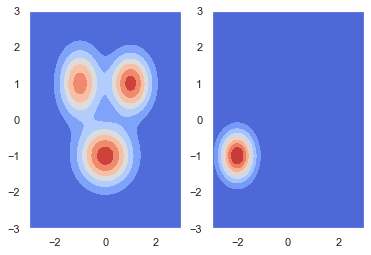

In [3]:
n_explorers = 4
wolves_per_day = 10
days = 5
read_prob = 0.5

mu = torch.tensor(
    [[
        [-2, -1],
        [-2, -1]
    ]]
)

var = torch.tensor(
    [[
        [0.2, 0.2],
        [0.2, 0.2],
    ]]
)

fox_den = GaussianMixture(
    n_components=2,
    n_features=2,
    mu_init=mu,
    var_init=var,
    covariance_type="diag")


fig, axs = plt.subplots(1, 2)
plot_distribution(wolf_dens, ax=axs[0], title=False, cbar=False)
plot_distribution(fox_den, ax=axs[1], title=False, cbar=False)
plt.show()

Estimates after day 1.


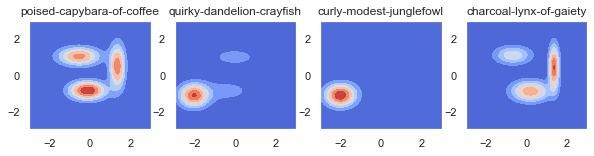

Estimates after day 2.


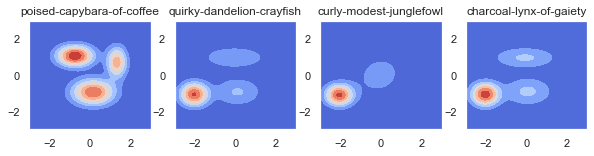

Estimates after day 3.


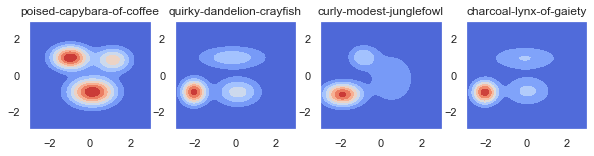

Estimates after day 4.


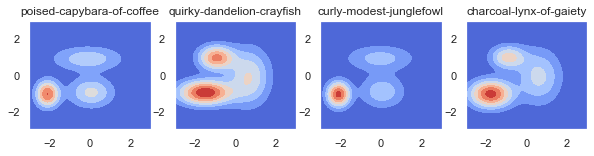

Estimates after day 5.


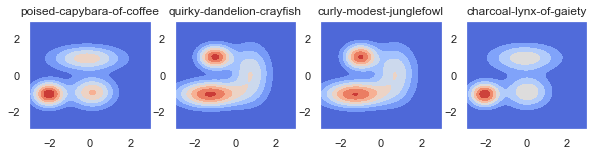

In [4]:
explorers = [Explorer() for _ in range(n_explorers)]

for day in range(days):
    for explorer in explorers:
        explorer.sample(wolves_per_day)

    fox_notes, _ = fox_den.sample(wolves_per_day * (days + 1))

    fig, axs = plt.subplots(1, n_explorers)
    fig.set_size_inches(10, 2)
    for explorer, ax in zip(explorers, axs):
        for other in explorers:
            if other != explorer and random() < read_prob:
                explorer.notes[other.name] = other.experiences.clone()
        if random() < read_prob:
            explorer.notes["fox"] = fox_notes

        explorer.fit(explorer.believed_locations(explorer.notes))
        explorer.display(show=False, ax=ax, cbar=False, title=explorer.name)

    print(f"Estimates after day {day + 1}.")
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.show()

We can see that the fox has successfully thwarted our explorers, who now have a very inaccurate map of the forest. 

But, lets look at the notes for one of our explorers. 

Note from spectral-peach-woodlouse


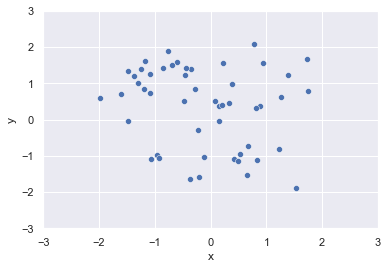

Note from amusing-herring-of-stamina


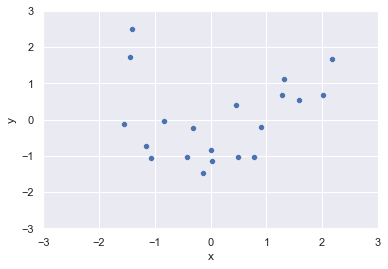

Note from hysterical-truthful-manatee


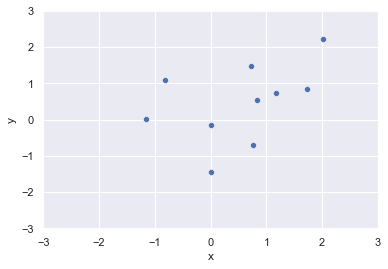

Note from fox


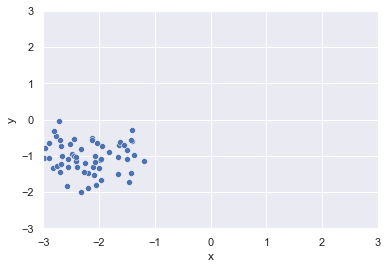

In [6]:
explorer = explorers[0]

for writer, note in explorer.notes.items():
    print(f"Note from {writer}")
    note_df = pd.DataFrame(
        {
            "x": note[:, 0],
            "y": note[:, 1],
            "writer": writer
        }
    )
    sns.scatterplot(data=note_df, x="x", y="y")
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.show()

### Looking at these notes... our explorers naturally start to become a bit suspicious. 

Most of the notes report wolf sightings in similar locations, but one note in particular is a huge outlier.

Our explorers decide they should simply ignore notes that are too different from what they have seen. To do this, we can fit a model to just the explorer's experiences, and then only include notes for training if they are likely under that model. 

You can think of this like doing a common sense "smell test" - if something is too far off from your understanding of things, it raises some alarm bells. 

We can see this below for explorer 1, showing the log likelihood of each note. Here, large negative numbers mean very unlikely notes!

Note from curly-modest-junglefowl. Likelihood: -2.573193311691284


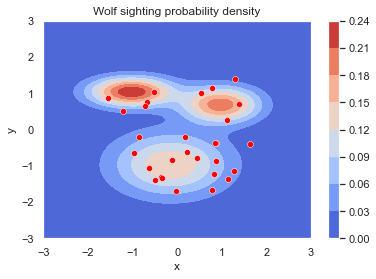

Note from charcoal-lynx-of-gaiety. Likelihood: -3.0781688690185547


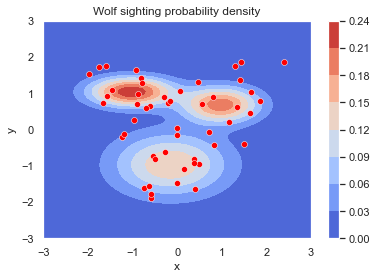

Note from quirky-dandelion-crayfish. Likelihood: -2.700233221054077


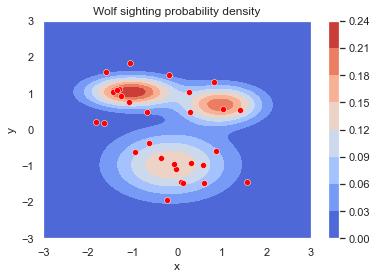

Note from fox. Likelihood: -4.733845233917236


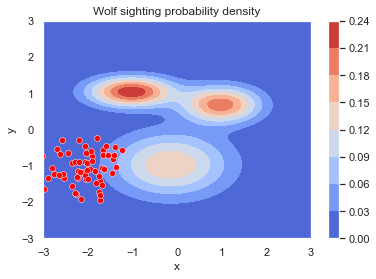

In [6]:
explorer = explorers[0]
explorer.fit(explorer.experiences)

for writer, note in explorer.notes.items():
    print(f"Note from {writer}. Likelihood: {explorer.model._score(note)}")
    note_df = pd.DataFrame(
        {
            "x": note[:, 0],
            "y": note[:, 1],
            "writer": writer
        }
    )
    explorer.display(show=False, title="Wolf sighting probability density")
    sns.scatterplot(data=note_df, x="x", y="y", color="red")
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.show()

### Aha!

Now that we have this quantified, we can see that all of the legitimate notes have log likelihoods around -3, meanwhile the fox's notes have a log likelihood of -13. The explorers decide to set a reasonable threshold of -4, agreeing to ignore notes that diverge from their internal model by more than that threshold. 

Estimates after day 1.


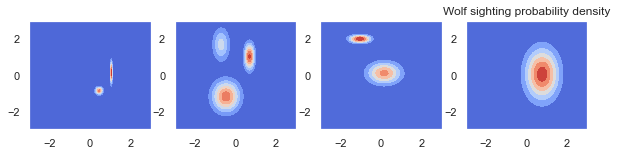

Estimates after day 2.


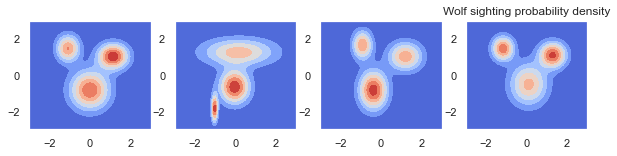

Estimates after day 3.


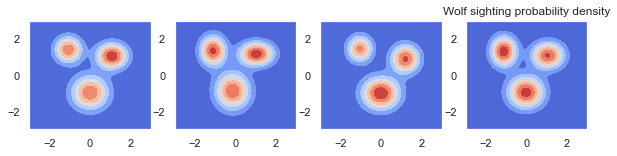

Estimates after day 4.


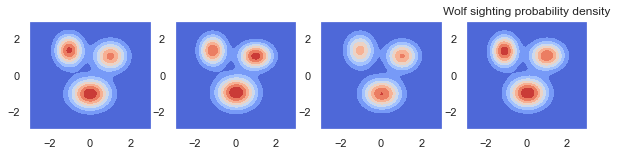

Estimates after day 5.


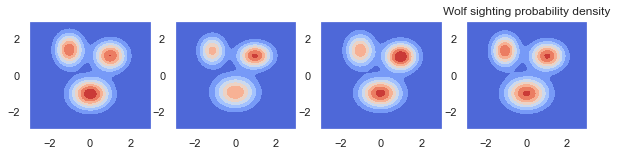

In [12]:
likelihood_threshold = -4
explorers = [Explorer() for _ in range(n_explorers)]

for day in range(days):
    for explorer in explorers:
        explorer.sample(wolves_per_day)

    fox_notes, _ = fox_den.sample(wolves_per_day * (days + 1))

    fig, axs = plt.subplots(1, n_explorers)
    fig.set_size_inches(10, 2)
    for explorer, ax in zip(explorers, axs):
        for other in explorers:
            if other != explorer and random() < read_prob:
                explorer.notes[other.name] = other.experiences.clone()
        if random() < read_prob:
            explorer.notes["fox"] = fox_notes
    
        if random() < read_prob:
            explorer.notes["fox"] = fox_notes
        explorer.fit(explorer.experiences)
        trusted_notes = {k:v for k, v in explorer.notes.items() if explorer.model._score(v) > likelihood_threshold}
        explorer.fit(explorer.believed_locations(trusted_notes))
        explorer.display(show=False, ax=ax, cbar=False, title=explorer.name)

    print(f"Estimates after day {day + 1}.")
    plt.show()

Hurrah! Our explorers have overcome the cunning fox... for now. 